In [130]:
import subprocess
from rpy2.robjects import r
from rc_data_class import RcData
from rc_folds_class  import rcFolds
from rc_pred_ann_model import PredAnnModel
from rc_individual_fold import RcFoldForANN
import numpy as np
import random
import pandas as pd
import random
import matplotlib.pyplot as plt


def get_genes_list(p_thresh, split_train):
    # Define the R script path
    r_script = "rc_get_diff_genes.r"
    
    # Build the command to run the R script
    command = ["Rscript", r_script, str(p_thresh), str(split_train)]
    
    result = subprocess.run(command, capture_output=True, text=True)
    
    # Check if the R script ran successfully
    if result.returncode == 0:
        print("R script executed successfully.")
    
        # Read the generated file
        rds_path = '/tmp/work/RCproject_code/sean_ann_python/ann_gene_set.rds'
        current_genes = r.readRDS(rds_path)
        print(len(current_genes))
        
    else:
        print("Error in R script execution:")
        print(result.stderr)

    return(current_genes.tolist())

def get_first_gen(n_pop,input_genes):
    first_gen = [];
    gene_list_length = len(input_genes)  # Length of the gene list
    for i in range(n_pop):
        binary_list = [random.choice([0, 1]) for _ in range(gene_list_length)]  # Create a binary list of the same length
        binary_array = np.array(binary_list)  # Convert binary list to a NumPy array
        first_gen.append(binary_array)

    return(first_gen)

def evaluate_individuals(input_gen,gene_list,folds,input_data,num_epochs):
    auc_averages = []
    current_folds = rcFolds(input_data,folds)
    current_gen_member = 1
    for gen_member in input_gen:
        filtered_list = np.array(genes_list)[gen_member == 1] # Use binary array to filter the genes list
        current_aucs = []
        for i in range(folds):
            current_fold = RcFoldForANN(current_folds,i)
            fold_count = i + 1
            print(f"Currently training, population member {current_gen_member}, with fold {fold_count}.")
            current_model = PredAnnModel(current_fold,current_genes, num_epochs = num_epochs)
            test_auc_list = current_model.test_auc_list
            current_auc = max(test_auc_list)
            current_aucs.append(current_auc)
        current_average_auc = np.mean(current_aucs)
        auc_averages.append(current_average_auc)
        current_gen_member += 1
    ga_df.loc[len(ga_df)] = auc_averages
    return auc_averages, input_gen

# Crossover function
def crossover_and_mutate(current_gen, current_aucs, mutation_rate):

    indices = np.argsort(current_aucs)[-2:][::-1]  # Sort, pick the last two, and reverse to get highest first
    parent1 = current_gen[indices[0]]
    parent2 = current_gen[indices[1]]
    
    # Ensure parents are the same size
    if len(parent1) != len(parent2):
        raise ValueError("Parents must have the same length.")

    # Randomly choose a crossover point
    crossover_point = random.randint(1, len(parent1) - 1)

    # Create children by combining parts of each parent
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child = bit_flip_mutation(child, mutation_rate)

    return child

def bit_flip_mutation(individual, mutation_rate=0.01):
    # Go through each gene in the individual
    for i in range(len(individual)):
        if random.random() < mutation_rate:  # If random number is below mutation rate, flip the gene
            individual[i] = 1 - individual[i]  # Flip 0 to 1, or 1 to 0
    return individual

def plot_row_averages(df):
    """
    Plots the average of each row in the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing numerical values.
    """
    row_averages = df.mean(axis=1)  # Compute the average across each row
    
    plt.figure(figsize=(10, 5))
    plt.plot(row_averages, marker='o', linestyle='-', color='b', label='Row Averages')
    
    plt.xlabel("Generation")
    plt.ylabel("Average Value")
    plt.title("Average of Each Row in DataFrame")
    plt.legend()
    plt.grid(True)
    
    plt.show()
    
ga_df = pd.DataFrame(columns = ['n_1','test_auc'])

population_size = 10
p_value = 0.1
split_train = True
folds = 5
num_epochs = 10
mutation_rate = 0.01
n_generations = 5

# making a data frame to keep track of GA progress
column_names = [f'auc_{i+1}' for i in range(population_size)]
# Initialize an empty DataFrame with columns
ga_df = pd.DataFrame(columns=column_names)


current_data = RcData()
genes_list = get_genes_list(p_value, split_train)
first_gen = get_first_gen(population_size,current_genes)
print("Now entering generation #: 1")
current_aucs, current_gen = evaluate_individuals(first_gen,genes_list,folds,current_data,num_epochs)

for i in range(n_generations):
    current_gen_number = i + 2
    print(f"Now entering generation #: {current_gen_number}")
    new_gen = []
    for x in range(population_size):
        child = crossover_and_mutate(current_gen,current_aucs,mutation_rate)
        new_gen.append(child)
    current_gen = new_gen
    current_aucs, current_gen = evaluate_individuals(current_gen,genes_list,folds,current_data,num_epochs)

plot_row_averages(ga_df)

Data successfully loaded.
R script executed successfully.
910
Currently training, population member 1, with fold 1.
Epoch 0, Average Outcome Loss: 0.7490127020412021, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.3378
Currently training, population member 1, with fold 2.
Epoch 0, Average Outcome Loss: 0.8111726972791884, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.3514
Currently training, population member 1, with fold 3.
Epoch 0, Average Outcome Loss: 0.8218831221262614, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.6486
Currently training, population member 1, with fold 4.
Epoch 0, Average Outcome Loss: 0.962012403541141, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.3514
Currently training, population member 1, with fold 5.
Epoch 0, Average Outcome Loss: 0.6795810129907396, Average Accuracy: 0.5902777777777778, Test AUC: 0.5000, Test Accuracy: 0.3425
Currently training, population member 2, with fold 1.
Epoch 0, Average Outcome Loss:

In [131]:
ga_df

,auc_1,auc_2,auc_3,auc_4,auc_5,auc_6,auc_7,auc_8,auc_9,auc_10
0,0.599405,0.615978,0.621216,0.627111,0.609955,0.596069,0.633681,0.572367,0.596883,0.609915
1,0.650838,0.584026,0.663896,0.622135,0.627961,0.593481,0.606199,0.647485,0.596607,0.633168
2,0.582427,0.559280,0.600744,0.597863,0.571228,0.622402,0.610793,0.599493,0.654412,0.599183
3,0.665173,0.607510,0.580831,0.608500,0.611105,0.588229,0.566426,0.618356,0.637221,0.642331
4,0.589717,0.655377,0.631869,0.604635,0.608647,0.568345,0.552122,0.600381,0.618132,0.629953
5,0.599840,0.595134,0.602304,0.599079,0.632559,0.546311,0.611880,0.673541,0.661457,0.573186


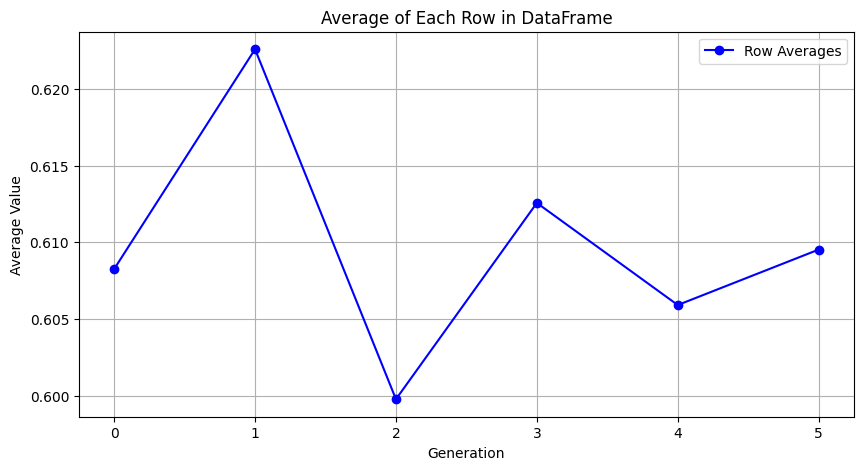

In [119]:
for i in range(n_generations):
    new_gen = []
    for x in range(population_size)
        child = crossover_and_mutate(current_gen,current_aucs,mutation_rate)
        new_gen.append(child)
    current_gen = new_gen
    current_aucs, current_gen = evaluate_individuals(current_gen,genes_list,folds,current_data,num_epochs)

    
        
    #establish_new gen

,auc_1,auc_2,auc_3,auc_4,auc_5
0,0.603861,0.571816,0.635418,0.590942,0.653681


In [81]:
# indices = np.argsort(first_aucs)[-2:][::-1]  # Sort, pick the last two, and reverse to get highest first
current_gen[indices[0]]


NameError: name 'current_gen' is not defined

In [83]:
first_gen

[array([2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1,
        2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1,
        2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2,
        2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1,
        2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1,
        2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2,
        1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2,
        1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
        1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1,
        1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2,
        2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1,
        2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 

In [82]:
first_gen[indices[0]]

array([2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1,
       1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1,
       1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1,
       2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2,
       2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1,
       1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,

In [46]:

# evaluate each list and return the list of averaged auc values

# write the aucs to a csv for later evaluation

# pick the best two lists based on auc values and breed to create 10 new children


# apply mutation rate


# go back to evalution step (simply nest it all in a for loop


910

In [51]:
# first_generation_lists[0]

filtered_list = np.array(genes_list)[first_gen[4] == 1] # Use binary array to filter the genes list
len(filtered_list)

456

In [ ]:
filtered_list = np.array(genes_list)[binary_array == 1] # Use binary array to filter the genes list


In [2]:
# import importlib
# import rc_folds_class  # This is the module containing the rcFolds class

# importlib.reload(rc_folds_class)  # Reload the module, not the class

test = rcFolds(current_data,5)
current_fold = RcFoldForANN(test,0)

In [4]:
current_model = PredAnnModel(current_fold,current_genes, num_epochs = 10)

test_accuracy_list = current_model.test_accuracy_list # list of metrics for evaluating the model
test_auc_list = current_model.test_auc_list # list of metrics for evaluating the model
train_accuracy_list = current_model.train_accuracy_list # list of metrics for evaluating the model
    
print(max(test_accuracy_list))
print(max(test_auc_list))
print(max(train_accuracy_list))

Epoch 0, Average Outcome Loss: 0.7013717359966702, Average Accuracy: 0.4236111111111111, Test AUC: 0.5000, Test Accuracy: 0.3378
tf.Tensor(0.6621622, shape=(), dtype=float32)
0.6897959183673469
0.5


In [4]:
for p_val in pvals:
    current_genes = get_genes_list(p_val, True)
    for x in range(3): 
        print('current pval is:')
        print(p_val)
        current_model = PredAnnModel(current_data,current_genes, num_epochs = 100)
        
        test_accuracy_list = current_model.test_accuracy_list # list of metrics for evaluating the model
        test_auc_list = current_model.test_auc_list # list of metrics for evaluating the model
        train_accuracy_list = current_model.train_accuracy_list # list of metrics for evaluating the model
            
        print(max(test_accuracy_list))
        print(max(test_auc_list))
        print(max(train_accuracy_list))
    
    
        p_val_perf_df.loc[i] = [p_val, max(test_auc_list)]
        i += 1

p_val_perf_df.to_csv('pval_series_auc.csv', index=False)


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'current_fold',
 'folds_object',
 'genes_list',
 'unique_combinations_array',
 'x_test',
 'x_train',
 'y_test_outcome',
 'y_train']

In [2]:
# current_gene_list = 'de_intersect_plus_bulk_genes'

# # Load the RDS file
# rds_path = '/tmp/work/RCproject/gene_lists.rds'
# rds_data = r.readRDS(rds_path)

# # Extract the names of the lists and their contents
# gene_lists = {}
# for name, item in zip(rds_data.names, rds_data):
#     # Each 'item' is a list associated with the 'name'
#     inner_list = list(item)  # Convert the inner R list to a Python list
#     gene_lists[name] = inner_list

# # Now `python_data` is a dictionary with names as keys and lists as values
# print(gene_lists.keys())

# current_genes = gene_lists[current_gene_list]

# print(len(current_genes))

In [3]:
# current_genes = get_genes_list(0.01, True)
# current_model = PredAnnModel(current_data,current_genes, num_epochs = 200)

# test_accuracy_list = current_model.test_accuracy_list # list of metrics for evaluating the model
# test_auc_list = current_model.test_auc_list # list of metrics for evaluating the model
# train_accuracy_list = current_model.train_accuracy_list # list of metrics for evaluating the model

# print(max(test_accuracy_list))
# print(max(test_auc_list))
# print(max(train_accuracy_list))

R script executed successfully.
55
Epoch 0, Average Outcome Loss: 0.7156119021502408, Average Accuracy: 0.48863636363636365, Test AUC: 0.5000, Test Accuracy: 0.6341
Epoch 100, Average Outcome Loss: 0.4514216997406699, Average Accuracy: 0.7840909090909091, Test AUC: 0.4974, Test Accuracy: 0.6098
tf.Tensor(0.73170733, shape=(), dtype=float32)
0.6948717948717948
0.9204545454545454


In [9]:
import pandas as pd

pvals = [0.01 * (i + 1) for i in range(20)]  # Adjust range for the number of values

p_val_perf_df = pd.DataFrame(columns = ['pval','test_auc'])

i = 0

for p_val in pvals:
    current_genes = get_genes_list(p_val, True)
    for x in range(3): 
        print('current pval is:')
        print(p_val)
        current_model = PredAnnModel(current_data,current_genes, num_epochs = 100)
        
        test_accuracy_list = current_model.test_accuracy_list # list of metrics for evaluating the model
        test_auc_list = current_model.test_auc_list # list of metrics for evaluating the model
        train_accuracy_list = current_model.train_accuracy_list # list of metrics for evaluating the model
            
        print(max(test_accuracy_list))
        print(max(test_auc_list))
        print(max(train_accuracy_list))
    
    
        p_val_perf_df.loc[i] = [p_val, max(test_auc_list)]
        i += 1

p_val_perf_df.to_csv('pval_series_auc.csv', index=False)


R script executed successfully.
55
current pval is:
0.01
Epoch 0, Average Outcome Loss: 0.8186877532438799, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.3659
tf.Tensor(0.68292683, shape=(), dtype=float32)
0.6897435897435897
0.7727272727272727
current pval is:
0.01
Epoch 0, Average Outcome Loss: 0.8378696658394553, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.3659
tf.Tensor(0.68292683, shape=(), dtype=float32)
0.6923076923076923
0.8238636363636364
current pval is:
0.01
Epoch 0, Average Outcome Loss: 0.7379782633347944, Average Accuracy: 0.5, Test AUC: 0.6667, Test Accuracy: 0.6341
tf.Tensor(0.6585366, shape=(), dtype=float32)
0.6692307692307692
0.8238636363636364
R script executed successfully.
137
current pval is:
0.02
Epoch 0, Average Outcome Loss: 0.689532382921739, Average Accuracy: 0.5454545454545454, Test AUC: 0.5000, Test Accuracy: 0.3659
tf.Tensor(0.6585366, shape=(), dtype=float32)
0.7307692307692308
0.7784090909090909
current pval is:
0.02
Epoch 0, Av

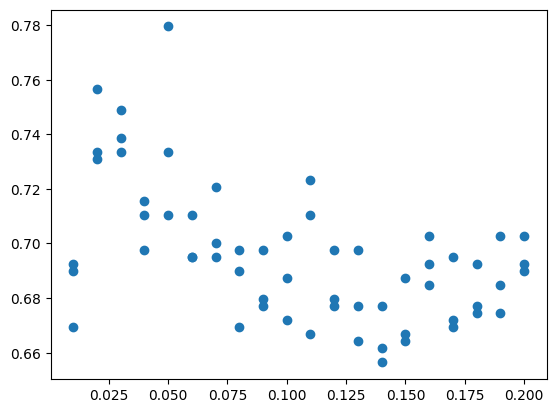

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(p_val_perf_df['test_auc'], p_val_perf_df['pval'])
plt.show()

In [ ]:
# pvals = [0.005 * (i + 1) for i in range(40)]  # Adjust range for the number of values

# for p_val in pvals:
#     print('current pval is:')
#     print(p_val)
#     current_genes = get_genes_list(p_val, True)
#     current_model = PredAnnModel(current_data,current_genes, num_epochs = 1000)
    
#     test_accuracy_list = current_model.test_accuracy_list # list of metrics for evaluating the model
#     test_auc_list = current_model.test_auc_list # list of metrics for evaluating the model
#     train_accuracy_list = current_model.train_accuracy_list # list of metrics for evaluating the model
    
#     print(max(test_accuracy_list))
#     print(max(test_auc_list))
#     print(max(train_accuracy_list))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# After training, plot the metrics

frequency_counts = pd.Series(current_data.y_test_outcome).value_counts()
test_chance_level = frequency_counts[0]/len(current_data.y_test_outcome)

frequency_counts = pd.Series(current_data.y_train_outcome).value_counts()
train_chance_level = frequency_counts[0]/len(current_data.y_train_outcome)

fig, axs = plt.subplots(3, 1, figsize=(12, 6))

x_values = np.arange(1, len(train_accuracy_list) + 1) * current_model.report_frequency

# Plot train accuracy
axs[0].plot(x_values, train_accuracy_list, label='Training Accuracy', color='blue')
axs[0].axhline(train_chance_level, color='black',linestyle ='--')
axs[0].set_title('Training set accuracy over epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Accuracy')
axs[0].grid()
axs[0].legend()

# Plot test accuracay
axs[1].plot(x_values, test_accuracy_list, label='Test Accuracy', color='orange')
axs[1].axhline(test_chance_level, color='black',linestyle ='--')
axs[1].set_title('Test set accuracy over epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Test Accuracy')
axs[1].grid()
axs[1].legend()

# Plot test accuracay
axs[2].plot(x_values, test_auc_list, label='Test AUC', color='orange')
# axs[2].axhline(0.5, color='black',linestyle ='--')
axs[2].set_title('Test set AUC over epochs')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Test AUC')
axs[2].grid()
axs[2].legend()

plt.tight_layout()
plt.show()